<img src="http://upravleniye-zakupkami.ru/wp-content/uploads/2019/09/RFM-Analytics-1080x675.jpg" width=600></br></br></br>
<h2 align="center">RFM-анализ покупателей онлайн-магазина</h2>

Импортируем необходимые библиотеки и подключаем датасет

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [54]:
# Подключаем датасет
df = pd.read_excel('Online Retail2.xls')
# Избавляемся от строчек с пустым Customer ID
df = df[df['CustomerID'].notnull()]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [56]:
# Смотрим на размерность датафрейма
df.shape

(36269, 8)

Препроцессинг датасета

In [55]:
# преобразуем дату в объект datetime
df['InvoiceDay'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))
df = df.drop(['InvoiceDate'], axis=1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01


Теперь нам нужно определить дату от которой будем считать разницу дней с последнего заказа
Т.к. наш датасет довольно старенький, возьмем +1 день к максимальной дате в датасете

In [4]:
# Смотрим на минимум и максимум дат
print('Min : {}, Max : {}'.format(min(df['InvoiceDay']), max(df['InvoiceDay'])))

Min : 2010-12-01 00:00:00, Max : 2011-01-14 00:00:00


In [56]:
# Фиксируем дату Макс+1 день
pin_date = max(df['InvoiceDay']) + dt.timedelta(1)

In [6]:
pin_date 

Timestamp('2011-01-15 00:00:00')

In [57]:
# Высчитываем сумму покупок
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [58]:
#Переведем CustomerID в строковый формат
df['CustomerID'] = df['CustomerID'].astype(int)
df['CustomerID'] = df['CustomerID'].astype(str)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,20.34


In [59]:
# Считаем значения RFM-метрик
rfm = df.groupby('CustomerID').agg({
    'InvoiceDay' : lambda x: (pin_date - x.max()).days, # разница между текущей датой и днем последнего заказа
    'InvoiceNo' : 'count', #кол-во заказов
    'TotalSum' : 'sum'}) #сумма выручки
# переименуем колонки
rfm.rename(columns = {'InvoiceDay' : 'Recency', 
                      'InvoiceNo' : 'Frequency', 
                      'TotalSum' : 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,39,31,711.79
12348,30,17,892.80
12359,3,16,547.50
12370,29,91,1868.02
12377,26,43,1001.52


In [60]:
rfm.shape

(1131, 3)

In [61]:
# Разбиваем набор значений каждой метрики на 4 равных квантиля
# и определяем каждое значение в соотв. квантиль. labels - это имена квантилей
r_labels = range(4, 0, -1) # массив (4,3,2,1) Для недавности нужно задавать обратный отсчет
r_groups = pd.qcut(rfm['Recency'], q = 4, labels = r_labels)
f_labels = range(1, 5) # массив (1,2,3,4)
f_groups = pd.qcut(rfm['Frequency'], q = 4, labels = f_labels)
m_labels = range(1, 5) # массив (1,2,3,4)
m_groups = pd.qcut(rfm['Monetary'], q = 4, labels = m_labels)

In [62]:
# Создем колонки значений на основе полученной сегментации
rfm['R'] = r_groups.values 
rfm['F'] = f_groups.values 
rfm['M'] = m_groups.values 
# Кодируем название сегмента на основе значений R-F-M
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
# Считаем RFM-score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347,39,31,711.79,1,3,4,1.03.04.0,8
12348,30,17,892.80,3,2,4,3.02.04.0,9
12359,3,16,547.50,4,2,3,4.02.03.0,9
12370,29,91,1868.02,3,4,4,3.04.04.0,11
12377,26,43,1001.52,3,4,4,3.04.04.0,11


In [63]:
# Считаем среднее значение каждой метрики по каждой группе RFM-score
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']# а по деньгам еще и кол-во
})
rfm_agg.round(1).head(12)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3            42.4       4.5     52.8    56
4            36.8       5.3     77.4   104
5            33.0      10.0    155.7   121
6            28.5      13.8    246.9   133
7            28.7      22.6    326.8   160
8            24.6      29.3    609.7   152
9            22.5      38.6    914.4   119
10           15.9      45.3    933.6   117
11           10.7      66.8   1479.0    87
12            4.2     105.6   2884.9    82

In [64]:
# Преобразуем RFM-Sore в шкалу - Железный, Бронзовый, Серебрянный, Золотой
score_labels = ['Iron', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm['RFM_Score'], q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12347,39,31,711.79,1,3,4,1.03.04.0,8,Silver
12348,30,17,892.80,3,2,4,3.02.04.0,9,Silver
12359,3,16,547.50,4,2,3,4.02.03.0,9,Silver
12370,29,91,1868.02,3,4,4,3.04.04.0,11,Gold
12377,26,43,1001.52,3,4,4,3.04.04.0,11,Gold


In [65]:
rfm.describe()
#В Monetary у нас есть отрицательные значения. Это может исказить наши дальнейшие расчеты
#Поэтому преобразуем такие значения в 1

,Recency,Frequency,Monetary,RFM_Score
count,1131.000000,1131.000000,1131.000000,1131.000000
mean,24.877984,32.068081,699.328727,7.519894
std,15.010178,43.809077,1783.155256,2.535815
min,1.000000,1.000000,-1192.200000,3.000000
25%,8.000000,9.000000,177.430000,6.000000
50%,30.000000,19.000000,320.150000,7.000000
75%,38.000000,40.000000,637.115000,10.000000
max,45.000000,684.000000,27834.610000,12.000000


In [66]:
rfm.loc[ rfm['Monetary'] <= 0, 'Monetary'] = 1

In [67]:
rfm.describe() #Теперь ок, минимум = 1

,Recency,Frequency,Monetary,RFM_Score
count,1131.000000,1131.000000,1131.000000,1131.000000
mean,24.877984,32.068081,705.340769,7.519894
std,15.010178,43.809077,1779.762537,2.535815
min,1.000000,1.000000,1.000000,3.000000
25%,8.000000,9.000000,177.430000,6.000000
50%,30.000000,19.000000,320.150000,7.000000
75%,38.000000,40.000000,637.115000,10.000000
max,45.000000,684.000000,27834.610000,12.000000


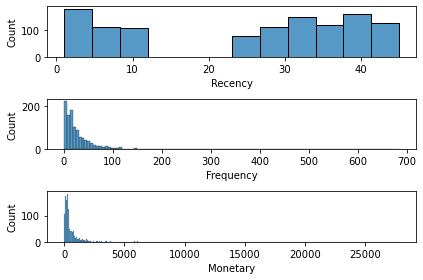

In [68]:
# Строим графики распределения RFM-значений
plt.subplot(3, 1, 1); sns.histplot(rfm['Recency'], label = 'Recency')
plt.subplot(3, 1, 2); sns.histplot(rfm['Frequency'], label = 'Frequency')
plt.subplot(3, 1, 3); sns.histplot(rfm['Monetary'], label = 'Monetary')

plt.tight_layout()
plt.show()

In [69]:
# Преобразуем каждую метрику к логарифму
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [70]:
rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,3.664,3.434,6.568
12348,3.401,2.833,6.794
12359,1.099,2.773,6.305
12370,3.367,4.511,7.533
12377,3.258,3.761,6.909


In [71]:
rfm_log.describe()

,Recency,Frequency,Monetary
count,1131.000000,1131.000000,1131.000000
mean,2.843169,2.840225,5.575674
std,1.052795,1.215734,1.744346
min,0.000000,0.000000,0.000000
25%,2.079000,2.197000,5.179000
50%,3.401000,2.944000,5.769000
75%,3.638000,3.689000,6.457000
max,3.807000,6.528000,10.234000


### Готовим клестеризацию методом K-средних

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [73]:
# Делаем нормализацию (mean = 0 и std = 1) (это условие для scikit-learn)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [75]:
# пребразуем его в pandas-датафрейм
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,0.780014,0.488625,0.569133
12348,0.530092,-0.005945,0.698752
12359,-1.657437,-0.055320,0.418294
12370,0.497783,1.374901,1.122594
12377,0.394203,0.757717,0.764709


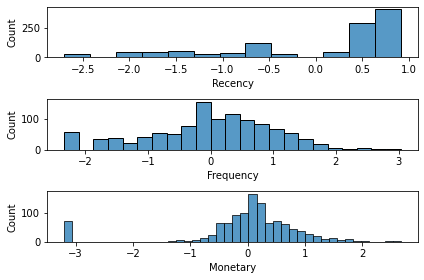

In [77]:
# строим графики нормализованных RFM-значений
plt.subplot(3, 1, 1); sns.histplot(rfm_scaled['Recency'], label = 'Recency')
plt.subplot(3, 1, 2); sns.histplot(rfm_scaled['Frequency'], label = 'Frequency')
plt.subplot(3, 1, 3); sns.histplot(rfm_scaled['Monetary'], label = 'Monetary')

plt.tight_layout()
plt.show()

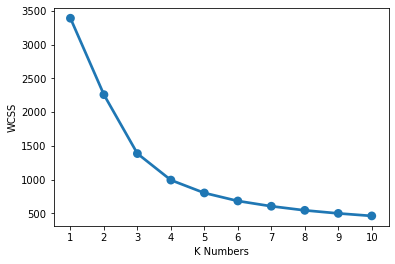

In [78]:
# Выбораем оптимальное число кластеров по методу “локтя”
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
# И сторим график
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

С возрастанием числа кластеров (K Numbers) уменьшается внутригрупповая сумма квадратов(WCSS)
Сначала резко, а затем не так сильно. Метод локтя назвается так по форме графика - он похож на согнутую в локте руку
Оптимальным числом кластеров будет позиция, где WCSS уже потеряла сущестенный вес, но не так сильно. Возьмем, к примеру 5.

In [79]:
# собственно клатсеризация
clus = KMeans(n_clusters= 5, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)
# добавляем результаты кластеризации в исходную матрицу
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
12347,39,31,711.79,1,3,4,1.03.04.0,8,Silver,2
12348,30,17,892.80,3,2,4,3.02.04.0,9,Silver,2
12359,3,16,547.50,4,2,3,4.02.03.0,9,Silver,1
12370,29,91,1868.02,3,4,4,3.04.04.0,11,Gold,2
12377,26,43,1001.52,3,4,4,3.04.04.0,11,Gold,2


In [81]:
# А теперь добавляем в нормализованную матрицу 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm['RFM_Level']
rfm_scaled.head()

,Recency,Frequency,Monetary,K_Cluster,RFM_Level
CustomerID,,,,,
12347,0.780014,0.488625,0.569133,2,Silver
12348,0.530092,-0.005945,0.698752,2,Silver
12359,-1.657437,-0.055320,0.418294,1,Silver
12370,0.497783,1.374901,1.122594,2,Gold
12377,0.394203,0.757717,0.764709,2,Gold


In [82]:
# разворачиваем датафрейм
rfm_scaled.reset_index(inplace = True)
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,CustomerID,RFM_Level,K_Cluster,Metrics,Value
0,12347,Silver,2,Recency,0.780014
1,12348,Silver,2,Recency,0.530092
2,12359,Silver,1,Recency,-1.657437
3,12370,Gold,2,Recency,0.497783
4,12377,Gold,2,Recency,0.394203


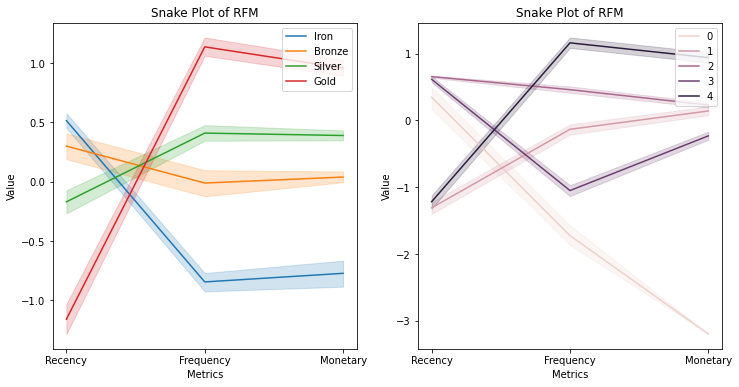

In [91]:
# Рисуем т.н. 'змеиный чарт'
fig = plt.figure(figsize=(12, 6))
area = fig.add_subplot(1, 2, 1)
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')
area = fig.add_subplot(1, 2, 2)               
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')              

Глядя на оба графика и сопоставляя направления и крутизну линий, мы можем предположить, что Iron соответствует кластеру 0,
а Gold - кластеру 4, а сегменты Bronze и Silver мы можем объеденить с кластерами 1,2 и 3.

Теперь поробуем сделать другим способом - с помощью тепловой карты (хтимэпа) и проверить,
будет ли у нас такой же результат.

In [92]:
# Считаем среднюю по каждой метрике 
total_avg = rfm.iloc[:, 0:3].mean()
total_avg

Recency       24.877984
Frequency     32.068081
Monetary     705.340769
dtype: float64

In [95]:
# Имеем Серию
type(total_avg)

pandas.core.series.Series

[]

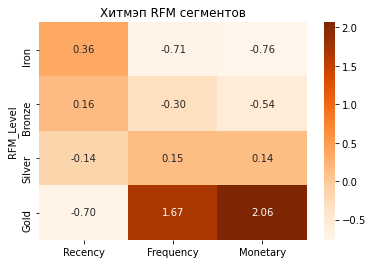

In [104]:
# считаем среднюю по метрикам в разрезе сегментов
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 0:3]
# делим на среднюю по самой метрике (с прошлого шага) 
prop_rfm = cluster_avg/total_avg - 1 
prop_rfm
# строим хитмэп
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Хитмэп RFM сегментов')
plt.plot()

[]

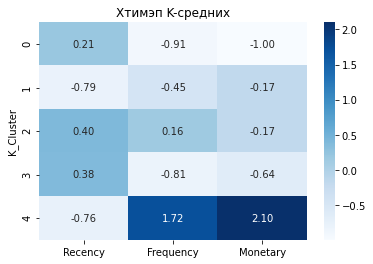

In [103]:
# Повторяем то же для K-клстеров
cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 0:3]
prop_rfm_K = cluster_avg_K/total_avg - 1
# строим хтимэп
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Хтимэп K-средних')
plt.plot()

[]

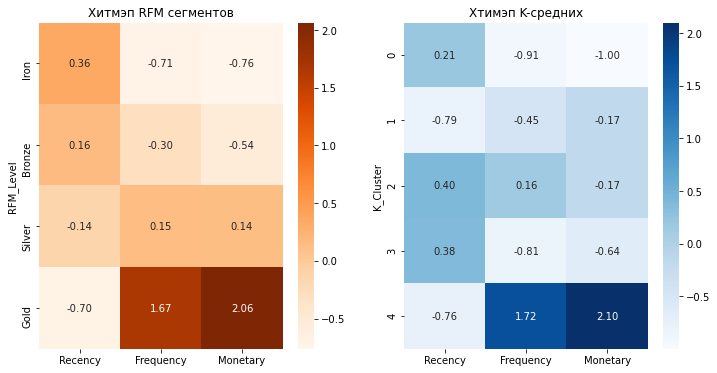

In [105]:
# Объеденим графики для удобного сравнения
fig = plt.figure(figsize=(12, 6))
area = fig.add_subplot(1, 2, 1)
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Хитмэп RFM сегментов')
plt.plot()

area = fig.add_subplot(1, 2, 2)
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Хтимэп K-средних')
plt.plot()

Мы видим, что сегмент Iron, примерно соответствует кластеру 0 по цвету и значениями. 
Gold - однозначно сектор 4. У Silver и Bronze соответствия не такие четко выраженные.

In [122]:
# Выведем CustomerID наших самых ценных клиентов из сегмента Gold и 4 кластера
fin = rfm_melted.loc[(rfm_melted['K_Cluster'] == 4)& (rfm_melted['RFM_Level'] == 'Gold'), ['CustomerID']]
fin

,CustomerID
5,12383
10,12415
20,12471
24,12480
25,12481
...,...
3335,17975
3346,18041
3359,18092
3364,18109
